In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from skimage import measure
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [3]:
sys.path.append('./../lung_cancer')
from radio.dataset import Dataset, FilesIndex, V, B
from radio.dataset.models.tf import TFModel
from radio.preprocessing import CTImagesMaskedBatch as CTIMB
from radio.preprocessing.mip import numba_xip

In [4]:
PATH = './blosce/*'
index = FilesIndex(path=PATH, dirs=True, no_ext=False)
dataset = Dataset(index=index, batch_class=CTIMB)
dataset.cv_split(0.9, shuffle=120)
dataset.indices.shape

(888,)

In [394]:
def make_component(batch, component, start, channels=None, squeeze=False):
    if isinstance(component, str):
        images = batch.unpack(component=component, data_format=None)
    else:
        images = component.reshape((1,) + component.shape)
    new_images = []
    for i in range(images.shape[0]):
        mode = 0 if squeeze else 0 # 0 - max, 1 - min, 2 - avg, 3 - median
        new_image = numba_xip(images[i], 6, mode, 2, start)
        if channels is None:
            new_image = np.expand_dims(new_image, axis=-1)
        else:
            d = len(new_image) % channels 
            if d > 0:
                new_image = new_image[:-d]
            t = np.transpose(new_image, (1, 2, 0))
            t = t.reshape(t.shape[:2] + (-1, channels))
            new_image = np.transpose(t, (2, 0, 1, 3))
            if squeeze:
                new_image = np.amax(new_image, axis=-1, keepdims=True)
        new_images.append(new_image)
    new_images = np.stack(new_images)
    new_images = new_images.reshape((-1,) + new_images.shape[2:])
    return new_images
    
def make_data(batch, channels=None, start=None):
    if start is None:
        start = np.random.randint(6)
    else:
        start = start
    batch.nimages = make_component(batch, 'images', start, channels=channels)
    batch.nmasks = make_component(batch, 'masks', start, channels=channels, squeeze=True)

In [395]:
def predict(batch, fmt='mip', start_pos=None, channels=3):
    model = batch.get_model_by_name('net')
    masks = np.zeros_like(batch.masks)
    divs = np.zeros((batch.masks.shape[0],1,1))
    if start_pos is None:
        start_pos = range(10,-1,-2) 
    for i in start_pos:
        make_data(batch, channels=channels, start=i)
        predict = model.predict(fetches='output_sigmoid',
                                feed_dict={
                                  'images': batch.nimages,
                                  'masks': batch.nmasks
                                })
        d = 6 # mip depth
        l = d + (channels - 1) * 2 # all channels depth
        for j in range(predict.shape[0]):
            masks[i+j*d:i+j*d+l] += predict[j,:,:,0]
            divs[i+j*d:i+j*d+l] += 1
    divs[divs < 1] = 1
    masks = masks / divs
    if fmt == 'mip':
        masks = make_component(batch, masks, start=0, channels=channels, squeeze=True)
    batch.pipeline.set_variable('predictions', masks)

In [7]:
def get_nodules(masks, batch=None, var=None):
    nodules = measure.label(masks > 0.5, background=0)
    if var is not None:
        batch.pipeline.set_variable(var, nodules)

    nods = dict()
    cnames = ['z', 'y', 'x']
    for i in range(1, nodules.max()):
        alln = np.where(nodules == i)
        nods[i] = dict()
        for j,c in enumerate(cnames): 
            nods[i][c] = np.floor(np.unique(alln[j]).mean()).astype('int')
    return nods

In [567]:
config = dict(
    load=dict(path='./MIP_ellipse_6_vnet/models/logloss'),
#    load=dict(path='./MIP_e_6_3c/models/UNet'), 
#    load=dict(path='./MIP_ellipse_6_3c_unet/models/logloss'),
#    load=dict(path='./MIP_ellipse_6_1c_unet/models/logloss'), #, checkpoint='model-140000.data-00000-of-00001'),
    session=dict(config=tf.ConfigProto(allow_soft_placement=True, gpu_options=tf.GPUOptions(visible_device_list='0'))),
)


In [568]:
view_pipeline = (
    dataset.test.p
      .load(fmt='blosc')
      .init_model('static', TFModel, 'net', config)
      .init_variables(['predictions', 'target_nodules', 'predicted_nodules'])
      .init_variable('start_pos', [0])
      .init_variable('fmt', 'mip')
      .call(predict, fmt=V('fmt'), start_pos=V('start_pos'), channels=3)
)

./MIP_ellipse_6_vnet/models/logloss/model-210000
INFO:tensorflow:Restoring parameters from ./MIP_ellipse_6_vnet/models/logloss/model-210000


In [250]:
model = view_pipeline.get_model_by_name('net')
model.global_step.eval(session=model.session)

210000

In [366]:
view_pipeline.set_variable('start_pos', [0])
view_pipeline.set_variable('fmt', 'mip')

In [367]:
view_pipeline.reset_iter()

In [571]:
%%time
batch = view_pipeline.next_batch(batch_size=1, shuffle=False)

if view_pipeline.get_variable('fmt') == 'mip':
    targets, images, predictions = batch.nmasks, batch.nimages, view_pipeline.get_variable('predictions')    
    targets = targets[:,:,:,0]
    images = images[:,:,:,0]
    predictions = predictions[:,:,:,0]
else:
    targets, images, predictions = batch.masks, batch.images, view_pipeline.get_variable('predictions')
    
predictions[predictions < .5] = 0
for image in predictions:
    if image.sum() < 5:
        image[:] = 0

print(batch.indices)
print(np.unique(np.where(targets > 0)[0]))
print(np.unique(np.where(predictions > 0)[0]))

slices = sorted(set(np.where(targets > 0)[0]) | set(np.where(predictions > 0)[0]))

['1.3.6.1.4.1.14519.5.2.1.6279.6001.320111824803959660037459294083']
[10 11]
[10 11]
CPU times: user 1.23 s, sys: 436 ms, total: 1.66 s
Wall time: 1.29 s


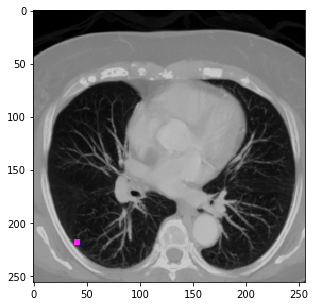

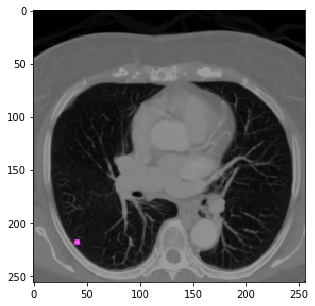

In [572]:
for k in slices:
    fig,ax = plt.subplots(1, 1, figsize=(5, 5))
    image = np.stack([images[k, :,:], images[k, :,:], images[k, :,:]], axis=-1)
    image = image / image.max()
    image[:,:,0] = image[:,:,0]  + targets[k, :,:]
    image[:,:,2] = image[:,:,2]  + predictions[k, :,:]
    ax.imshow(image/image.max())